In [14]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


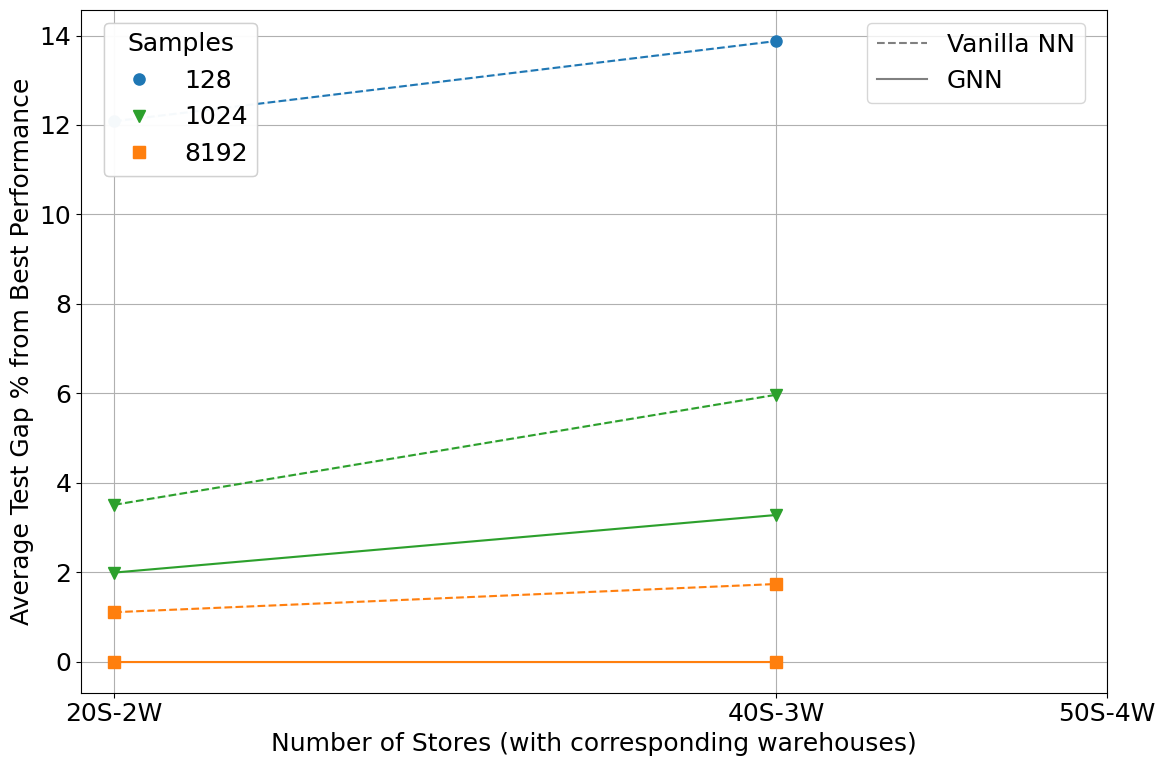

In [21]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_20_2", "n_warehouse_40_3"]#, "n_warehouse_50_4"]
store_warehouse_pairs = {
    20: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla NN": "--",  # Dashed
    "GNN": "-",         # Solid
}

# Define paths for each architecture
architectures = {
    "Vanilla NN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/vanilla_n_warehouses',
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample sizes
store_sizes = [20, 40, 50]  # Corresponding to the testset names
sample_sizes = [128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        for sample_size in sample_sizes:
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'samples': [1]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                test_loss_limit = 100)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['n_warehouses'] = warehouse_size
            df['n_stores'] = store_size
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_sample_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
    
    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []
                
            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                      (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': store_size,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Test Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [19]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,Vanilla NN,128,Vanilla NN,1,0.001,6.280687,6.657307,6.701958,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
1,1,Vanilla NN,1024,Vanilla NN,1,0.001,6.115201,6.198709,6.189156,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
2,1,Vanilla NN,8192,Vanilla NN,1,0.001,6.018167,6.056947,6.045554,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
3,1,Vanilla NN,128,Vanilla NN,1,0.001,6.179406,6.577081,6.613046,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
4,1,Vanilla NN,1024,Vanilla NN,1,0.001,6.004388,6.150648,6.153812,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
5,1,Vanilla NN,8192,Vanilla NN,1,0.001,5.928485,5.909051,5.908074,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
6,1,GNN,1024,GNN,1,0.001,6.072073,6.106245,6.102061,2,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
7,1,GNN,8192,GNN,1,0.001,5.978299,5.997383,5.983303,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
8,1,GNN,1024,GNN,1,0.001,5.990970,6.010973,6.006690,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
9,1,GNN,8192,GNN,1,0.001,5.851257,5.819262,5.820043,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
